# Computer Vision 2024 Assignment 3: Deep Learning for Perception Tasks 

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question is a more challenging classification experiment on a larger dataset. Answer the questions in separate Python notebooks.

## Question 1: A simple classifier, 20 marks

For this exercise, we provide demo code showing how to train a network on a small dataset called [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Please run through the code "tutorial-style" to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network.

For the Fashion-MNIST dataset the lables from 0-9 correspond to various clothing classes so you might find it convenient to create a python list as follows:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure.

Organize your own text and code cell to show the answer of each questions.

Detailed requirements:

**Q1.1 (1 point)**

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels.

**Q1.2 (2 points)**

Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

|Lr|Accuracy|
|---|---|
|1   |  10%    |
|0.1|     87.5%     |
|0.01|    83.6%     |
|0.001  | 70.5%        |


**Q1.3 (3 points)**

Report the number of epochs when the accuracy reaches 85%. Fill in the table below and plot the loass curve for each experiment:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |  10%    |  >500   |
|0.1|    85.6%      |   3 |
|0.01|    85.3%     |  14  |
|0.001  |   85%     |  123   |

**Q1.4 (2 points)**

Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?


**Q1.5 (5 points)**

Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |  86%    |669.706|
|Deeper|    88.1%      | 1.863.690 |
|Wider|    87.6%     |844.522|


**Q1.6 (2 points)**

Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

For more exlanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

**Q1.7 (5 points)**

Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with rehgard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [1]:
import numpy as np # This is for mathematical operations

# this is used in plotting
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display
from torchsummary import summary
from tqdm import tqdm

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset.
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import random

seed = 3
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Download training data from open datasets.
##Every TorchVision Dataset includes two arguments:
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
)

**NOTE**: For consistency with the original data set, we call our validation data "test_data". It is important to keep in mind though that we are using the data for model validation and not for testing the final, trained model (which requires data not used when training the model parameters).

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Add in a code cell to inspect the training data, as per Q1.1. Each element of the training_data structure has a greyscale image (which you can use plt.imshow(img[0,:,:]) to display, just like you did in previous assignments.  

### Q1.1
Q: Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels.

A: 

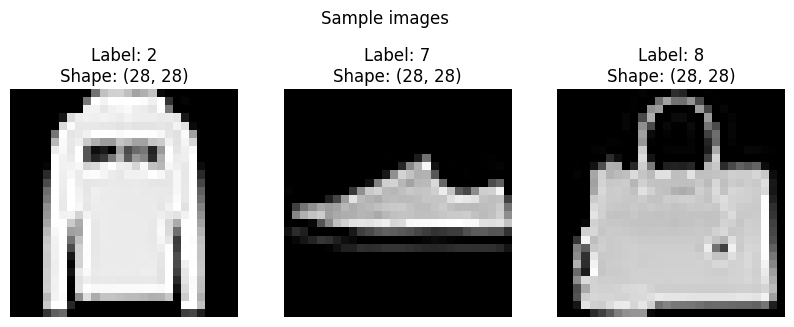

In [4]:
# Code cell for training image display

images, labels = next(iter(train_dataloader))
sample_index = [0, 1, 3]
# Display the images
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for idx, i in enumerate(sample_index):
    axes[idx].imshow(images[i][0,:,:], cmap='gray')
    axes[idx].set_title(f"Label: {labels[i].item()}\nShape: {tuple(images[i].size()[1:])}")
    axes[idx].axis('off')

fig.suptitle('Sample images')
plt.show()

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [5]:
# Get cpu or gpu device for training.
device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cuda" if torch.cuda.is_available() else "cpu"

print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork()
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [7]:
def train(dataloader, model, loss_fn, optimizer, pprint=True):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if pprint:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        average_loss = total_loss / num_batches

    return average_loss

In [8]:

##Define a test function
def test(dataloader, model, loss_fn, pprint=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    if pprint:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, 100*correct


In [9]:
def plot_loss(train_loss, test_loss):
    plt.plot(train_loss, label='train loss', color='blue', marker='o')
    plt.plot(test_loss, label='test loss', color='red', marker='o')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.show()


### Q1.2
Q: Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

A:

|Lr|Accuracy|
|---|---| 
|1   |  10%    |
|0.1|     87.5%     |
|0.01|    83.6%     |
|0.001  | 70.5%        |

As observed in the table above, the learning rate of 0.1 achieved the highest accuracy of 87.5% after 10 epochs. This tells us that the biggest or the smallest learning rate is not always the best. For each problem, we need to find the optimal learning rate to achieve the best result.

Furthermore, the loss curve for each experiment could be seen below. The learning rate of 0.0001 and 0.001 has a smooth curve, while the learning rate of 0.1 has a fluctuating curve. On the other hand, the learning rate of 1 is not decreasing at all. These graphs show us that a constant movement of the loss curve does not always mean that the learning rate is too small. It could also mean that the learning rate is too big.

However, despite the learning rate of 0.1 achieved the highest accuracy, it could be seen that the model is overfitting and the validation loss is starting to increase. Thus, the learning rate of 0.01 would be better to use.

Result from running the code:

In [10]:
learning_rates = [0.001, 0.01, 0.1, 1]

train_loss = {lr: [] for lr in learning_rates}
test_loss = {lr: [] for lr in learning_rates}

epochs = 10
for lr in learning_rates:
    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    print(f'Learning Rate: {lr}')
    for t in range(epochs):
        train_loss[lr].append(train(train_dataloader, model, loss_fn, optimizer, pprint=False))
        test_l, test_acc = test(test_dataloader, model, loss_fn, pprint=False)
        test_loss[lr].append(test_l)
    print(f'Test Accuracy: {(test_acc):>0.1f}%\n ')


Learning Rate: 0.001
Test Accuracy: 70.5%
 
Learning Rate: 0.01
Test Accuracy: 83.6%
 
Learning Rate: 0.1
Test Accuracy: 87.5%
 
Learning Rate: 1
Test Accuracy: 10.0%
 


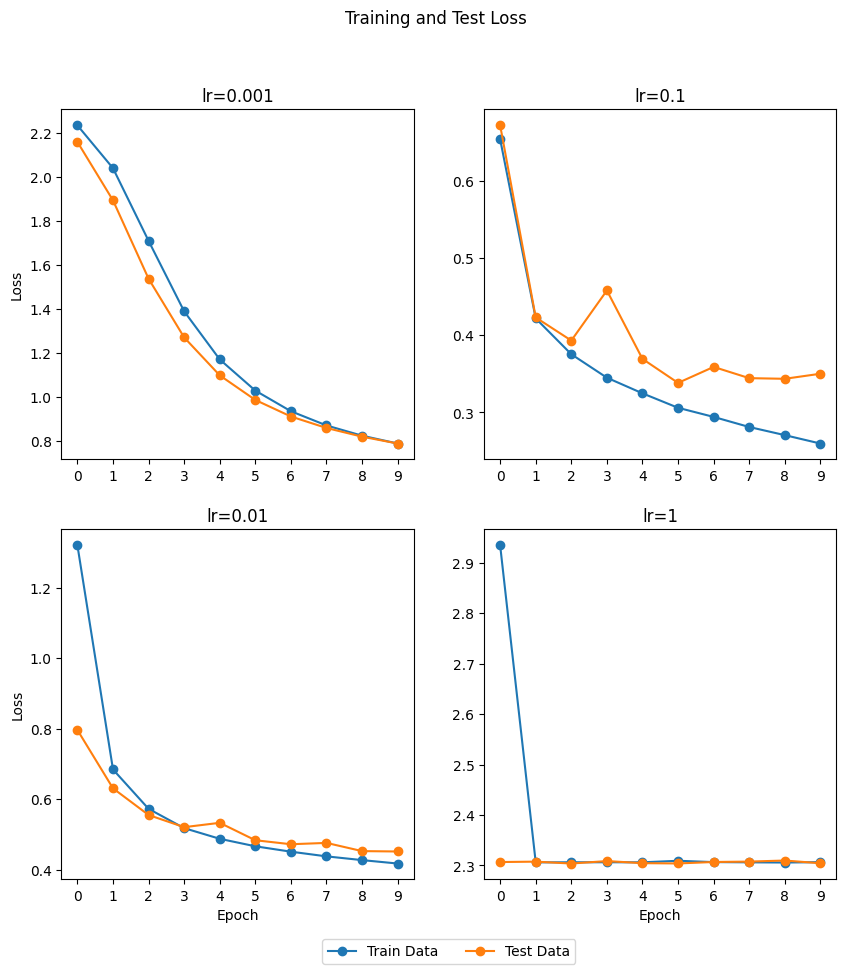

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, lr in enumerate(learning_rates):
    axs[i%2, i//2].plot(train_loss[lr], label='Train Data', marker='o')
    axs[i%2, i//2].plot(test_loss[lr], label='Test Data', marker='o')
    axs[i%2, i//2].set_title(f'lr={lr}')
    axs[i%2, i//2].set_xticks(range(epochs))

axs[0,0].set_ylabel('Loss')
axs[1,0].set_ylabel('Loss')
axs[1,0].set_xlabel('Epoch')
axs[1,1].set_xlabel('Epoch')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15), ncol=2)
fig.suptitle('Training and Test Loss')
plt.show()

### Q1.3
Q: Report the number of epochs when the accuracy reaches 85%. Fill in the table below and plot the loass curve for each experiment:

A: 

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |  10%    |  >500   |
|0.1|    85.6%      |   3 |
|0.01|    85.3%     |  14  |
|0.001  |   85%     |  123   |

A learning rate of 0.1 requires only 3 epochs to reach 85% accuracy. Similarly, a learning rate of 0.01 achieves this accuracy in 14 epochs. Conversely, a learning rate of 0.001 is too small, it needs 123 epochs to reach 85% accuracy. A learning rate of 1 fails to achieve 85% accuracy even after 500 epochs, as can be seen on the loss curve, which does not decrease as the epochs increase.

Result from running the code:

In [ ]:
learning_rates =  [0.001, 0.01, 0.1, 1]

train_loss = {lr: [] for lr in learning_rates}
test_loss = {lr: [] for lr in learning_rates}

max_iter = 500

for lr in learning_rates:
    model = NeuralNetwork().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    print(f'Learning Rate: {lr}')
    test_acc = 0
    while test_acc < 85 and len(test_loss[lr]) < max_iter:
        train_loss[lr].append(train(train_dataloader, model, loss_fn, optimizer, pprint=False))
        test_l, test_acc = test(test_dataloader, model, loss_fn, pprint=False)
        test_loss[lr].append(test_l)
    print(f'Test Accuracy: {(test_acc):>0.1f}%\n ')


Learning Rate: 0.001
Test Accuracy: 85.0%
 
Learning Rate: 0.01
Test Accuracy: 85.3%
 
Learning Rate: 0.1
Test Accuracy: 85.6%
 
Learning Rate: 1
Test Accuracy: 10.0%
 


In [ ]:
print('Number of Iteration per Learing Rate to reach 85% accuracy')

Number of Iteration per Learing Rate to reach 85% accuracy


In [ ]:
for k, v in test_loss.items():
    print(f'Learning Rate = {k}\nNumber of Iteration {len(v)}\n')

Learning Rate = 0.001
Number of Iteration 123

Learning Rate = 0.01
Number of Iteration 14

Learning Rate = 0.1
Number of Iteration 3

Learning Rate = 1
Number of Iteration 500



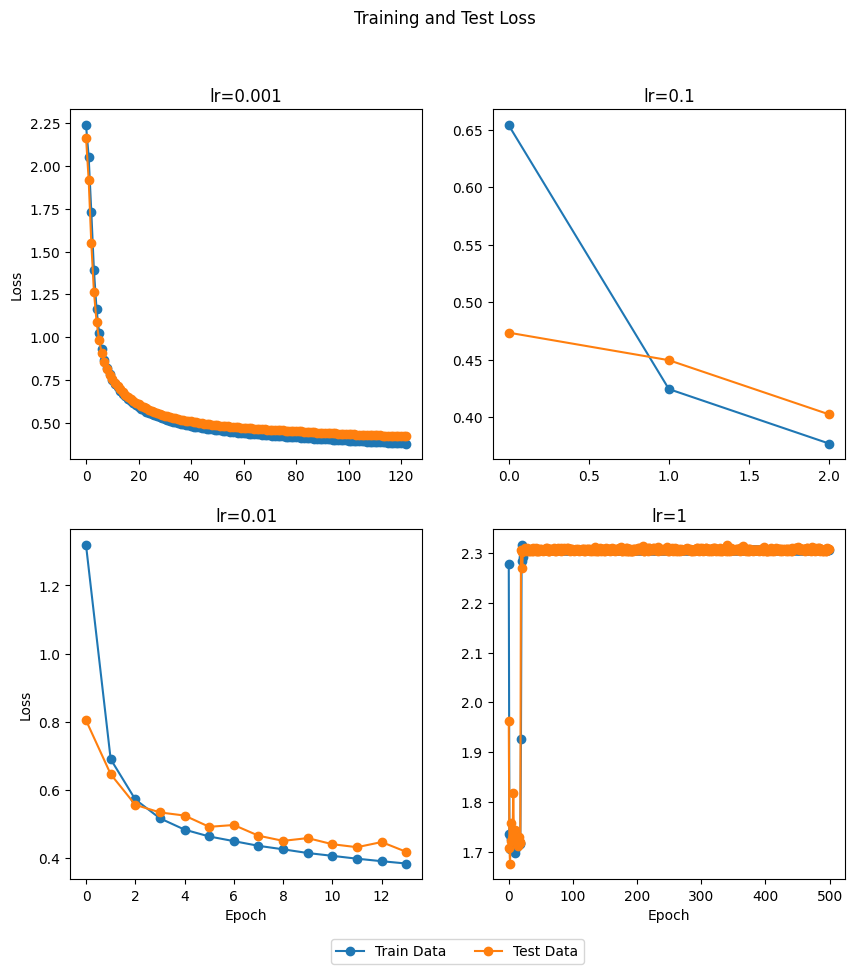

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, lr in enumerate(learning_rates):
    axs[i%2, i//2].plot(train_loss[lr], label='Train Data', marker='o')
    axs[i%2, i//2].plot(test_loss[lr], label='Test Data', marker='o')
    axs[i%2, i//2].set_title(f'lr={lr}')
    # axs[i%2, i//2].set_xticks(range(epochs))

axs[0,0].set_ylabel('Loss')
axs[1,0].set_ylabel('Loss')
axs[1,0].set_xlabel('Epoch')
axs[1,1].set_xlabel('Epoch')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15), ncol=2)
fig.suptitle('Training and Test Loss')
plt.show()

### Q1.4
Q: Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?

A: Learning rate is like any other hyper-parameter which the number should not be too big or to small. If the learning rate is too big, for example like learning rate equals to 1, the model always "overstep" the best weight or parameters, thus making the model could not learn anything from the data. That was indicated by the constant loss function. On the other hand, if the learning rate is to small, for example 0.001, the model takes a lot of epoch to reach the optimal performance. This is also not a good practice when dealing with a Big Dataset and complex model. In conclusion, the learning rate has to be picked which is not to big or to small, for example like learning rate equals to 0.1 or 0.01. These values gives a good result for this problem / dataset.

### Q1.5

Q: Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

A:

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |  86%    |669.706|
|Deeper|    88.1%      | 1.863.690 |
|Wider|    87.6%     |844.522|

Given that the optimal learning rate is 0.1, we will use this rate for the current analysis. All models are trained using 20 epochs with the same optimizer.

As shown in the table above, the deeper model achieved the highest accuracy at 88.1%. The wider model followed with an accuracy of 87.6% and utilized fewer parameters. The base model attained an accuracy of 86%, with less than half the number of parameters compared to the deeper model.

The loss curve for the deeper model is the smoothest, indicating greater stability, while the loss curves for the other models show more fluctuations. This suggests that the deeper model is more robust and less prone to overfitting.




In [ ]:
class NeuralNetworkDeep(nn.Module):
    def __init__(self):
        super(NeuralNetworkDeep, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 124),
            nn.ReLU(),
            nn.Linear(124, 124),
            nn.ReLU(),
            nn.Linear(124, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

In [ ]:
class NeuralNetworkWide(nn.Module):
    def __init__(self):
        super(NeuralNetworkWide, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

In [ ]:
lr = 1e-1
epochs = 20

Result from running the code:

In [ ]:
base_model = NeuralNetwork().to(device)
wide_model = NeuralNetworkWide().to(device)
deep_model = NeuralNetworkDeep().to(device)

nn_models = {'base': base_model, 'wide': wide_model, 'deep':deep_model}

train_loss_q5 = {'base': [], 'wide': [], 'deep':[]}
test_loss_q5 = {'base': [], 'wide': [], 'deep':[]}

for name, model in nn_models.items():
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    print(f'Model Type: {name}')
    for t in range(epochs):
        train_loss_q5[name].append(train(train_dataloader, model, loss_fn, optimizer, pprint=False))
        test_l, test_acc = test(test_dataloader, model, loss_fn, pprint=False)
        test_loss_q5[name].append(test_l)
    print(f'Test Accuracy: {(test_acc):>0.1f}%\n ')


Model Type: base
Test Accuracy: 86.0%
 
Model Type: wide
Test Accuracy: 88.1%
 
Model Type: deep
Test Accuracy: 87.6%
 


In [ ]:
base_model_total_params = sum(p.numel() for p in base_model.parameters())
wide_model_total_params = sum(p.numel() for p in wide_model.parameters())
deep_model_total_params = sum(p.numel() for p in deep_model.parameters())

print('Number of Parameters for each Model:')
print(f'Base Model Total Parameters: {base_model_total_params}')
print(f'Wide Model Total Parameters: {wide_model_total_params}')
print(f'Deep Model Total Parameters: {deep_model_total_params}')

Number of Parameters for each Model:
Base Model Total Parameters: 669706
Wide Model Total Parameters: 1863690
Deep Model Total Parameters: 844522


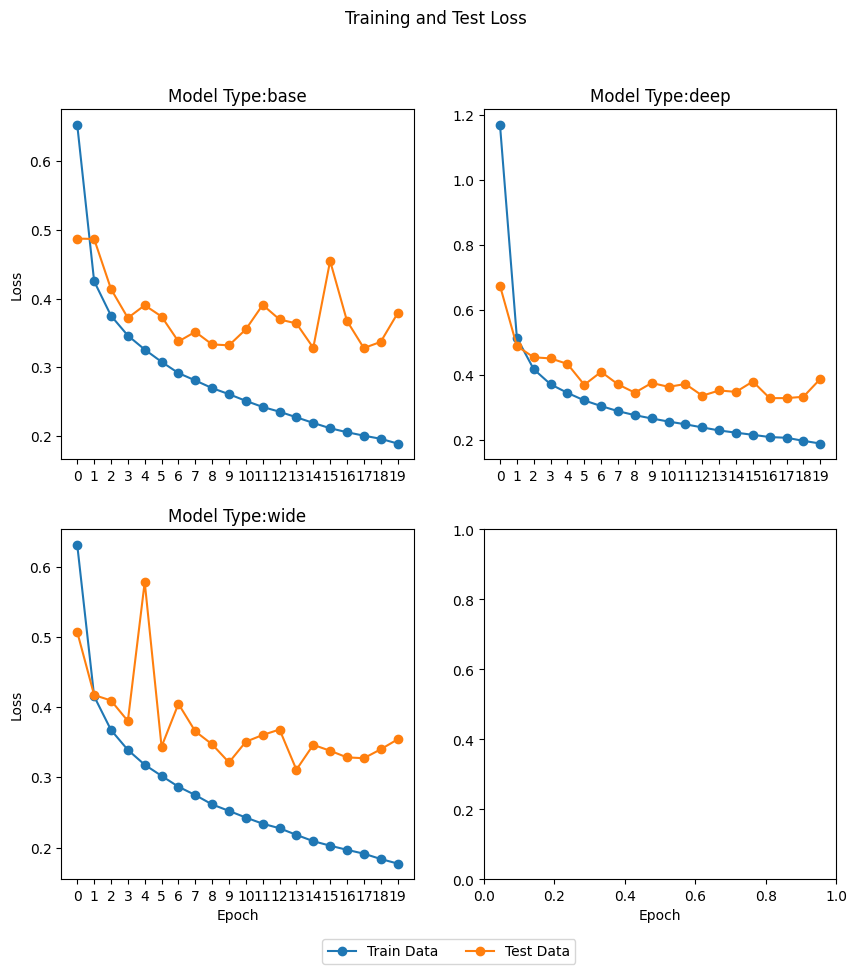

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, name in enumerate(nn_models.keys()):
    axs[i%2, i//2].plot(train_loss_q5[name], label='Train Data', marker='o')
    axs[i%2, i//2].plot(test_loss_q5[name], label='Test Data', marker='o')
    axs[i%2, i//2].set_title(f'Model Type:{name}')
    axs[i%2, i//2].set_xticks(range(epochs))

axs[0,0].set_ylabel('Loss')
axs[1,0].set_ylabel('Loss')
axs[1,0].set_xlabel('Epoch')
axs[1,1].set_xlabel('Epoch')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.15), ncol=2)
fig.suptitle('Training and Test Loss')
plt.show()

### Q1.6

Q: Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

A: 
In the first experiment, I used a batch size of 10,000 with a learning rate of 0.001 and 50 epochs to achieve a smooth mean gradient curve. However, as observed in the graph, the mean gradient fluctuates significantly but decreases as the training steps increase. In the second experiment, the mean gradient was calculated using the same learning rate but with the entire dataset of 60,000 samples. Using the entire dataset resulted in a smoother mean gradient that decreased more consistently with training steps, indicating better learning due to the larger data size.

These experiments demonstrate that using the entire dataset reduces noise and produces a smoother gradient mean compared to using a batch of data. However, batch data processing is faster and still shows a decreasing trend similar to the entire dataset.

In [40]:
def get_gradient_train(dataloader, model, loss_fn, optimizer):
    # size = len(dataloader.dataset)
    model.train()
    mean_gradients = []

    for _, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # Calculate the mean gradient for each step
        total_grad = 0
        num_params = 0
        
        for p in model.parameters():
            if p.grad is not None:
                total_grad += p.grad.data.abs().sum()
                num_params += p.numel()
        mean_grad = total_grad / num_params
        mean_gradients.append(mean_grad.item())
        
        optimizer.step()

    return mean_gradients

In [41]:
# calculate gradients with 10.000 samples
gradients = []
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
epochs=50
train_dataloader_q16 = DataLoader(training_data, batch_size=10000, shuffle=True)

for t in range(epochs):
  gradients += get_gradient_train(train_dataloader_q16, model, loss_fn, optimizer)

In [ ]:
# calculate gradients with full batch
gradients_full_batch = []
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
epochs=100
train_dataloader_q16 = DataLoader(training_data, batch_size=60000, shuffle=True)

for t in tqdm(range(epochs)):
  gradients_full_batch += get_gradient_train(train_dataloader_q16, model, loss_fn, optimizer)

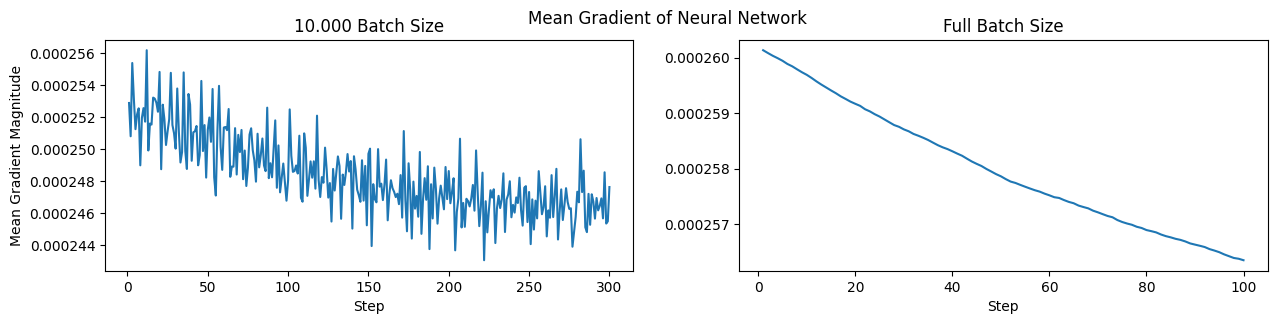

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

axs[0].plot(range(1, len(gradients) + 1), gradients)
axs[0].set_title('10.000 Batch Size')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Mean Gradient Magnitude')

axs[1].plot(range(1, len(gradients_full_batch) + 1), gradients_full_batch)
axs[1].set_title('Full Batch Size')
axs[1].set_xlabel('Step')

fig.suptitle('Mean Gradient of Neural Network')
plt.show()

### Q1.7
Q: Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with rehgard to convergence, accuracy and number of parameters, relative to MLPs.  

A: Despite CNN has more layers than MLP model, the number of parameters in CNN is less than MLP model, which are 157.566 and 669.706, respectively. Furthermore, both of the model were trained using the same optimezer and learning rate for 20 epochs, so that it could be compared. The CNN exceeded the MLP model in terms of accuracy. The CNN model could achieve 91.4% of validation accuracy, while the MLP model could only achieve 87.7% of validation accuracy. Additionally, the CNN model also converged faster than the MLP model. This could be seen in the loss curve, where the CNN model converged after 5 epochs, while the MLP model loss curve was still fluctuating after 20 epochs.

In [113]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5,padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.fc1 = nn.Linear(4*4*64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [121]:
print('Summary of Neural Network Model')
summary(NeuralNetwork(), (1,28,28))

Summary of Neural Network Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


In [122]:
print('Summary of CNN Model')
summary(CNN(), (1,28,28))

Summary of CNN Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 120]         123,000
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 157,566
Trainable params: 157,566
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.60
Estimated Total Size (MB): 0.84
----------------------

In [117]:
# Key Parameters
epochs = 20
lr = 1e-1

In [ ]:
cnn_model = CNN().to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

train_loss_cnn = []
test_loss_cnn = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_cnn.append(train(train_dataloader, cnn_model, loss_fn, optimizer, pprint=True))
    test_l, test_acc_cnn = test(test_dataloader, cnn_model, loss_fn, pprint=True)
    test_loss_cnn.append(test_l)


In [ ]:
model_nn = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model_nn.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

train_loss_nn = []
test_loss_nn = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_nn.append(train(train_dataloader, model_nn, loss_fn, optimizer, pprint=True))
    test_l, test_acc_nn = test(test_dataloader, model_nn, loss_fn, pprint=True)
    test_loss_nn.append(test_l)


In [119]:
print('Accuracy Comparison:')
print(f'NN Test Accuracy: {(test_acc_nn):>0.1f}%')
print(f'CNN Test Accuracy: {(test_acc_cnn):>0.1f}%')

Accuracy Comparison:
NN Test Accuracy: 87.7%
CNN Test Accuracy: 91.4%


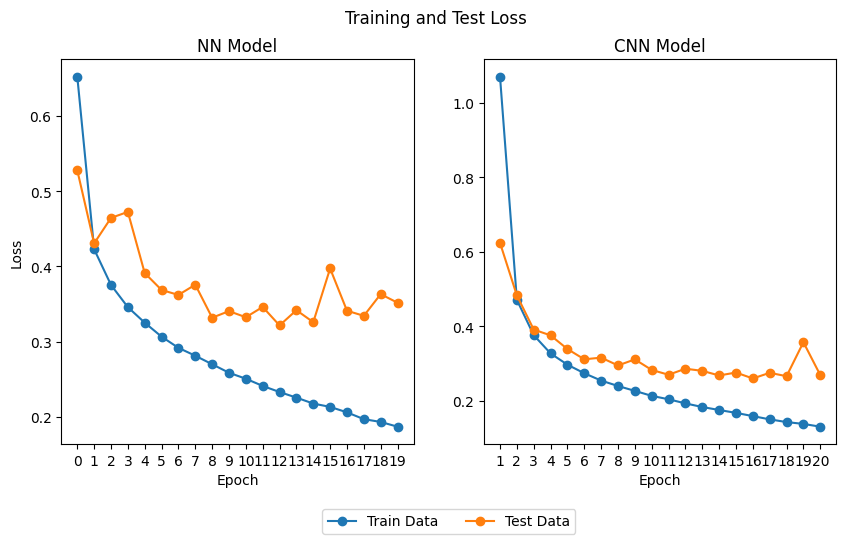

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_loss_nn, label='Train Data', marker='o')
axs[0].plot(test_loss_nn, label='Test Data', marker='o')
axs[0].set_title(f'NN Model')
axs[0].set_xticks(range(epochs))

axs[1].plot(train_loss_cnn, label='Train Data', marker='o')
axs[1].plot(test_loss_cnn, label='Test Data', marker='o')
axs[1].set_title(f'CNN Model')
axs[1].set_xticks(range(epochs), labels=range(1,epochs+1))

axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15), ncol=2)
fig.suptitle('Training and Test Loss')
plt.show()